## Aggregations and Composites

Aggregation involves summarizing data by reducing its dimensionality or condensing its values. Common aggregation operations include mean, sum, median, max, min, and more.

Composites are created by combining multiple datasets or multiple observations into a single dataset, typically to represent the best or a representative view over a period or area.

Reasons for the abovementioned operations:
1. Cloud-Free Imagery
2. Temporal Analysis
3. Detect Patterns
4. Noise Reductions
5. Simplification

***

### Loading Required Libraries

In [2]:
import pyproj
import pystac_client
import xarray as xr
from shapely.geometry import box
from shapely.ops import transform
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client
import odc.stac
from odc.geo.geobox import GeoBox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from geogif import gif, dgif
from dea_tools.plotting import display_map, rgb

In [5]:
def digitize_date(month,day):    
    if month<10:
        month=f'0{month}'
    
    if day<10:
        day=f'0{day}'
    
    return month,day

# STAC connection information for Sentinel 2 COGs
STAC_URL = "https://earth-search.aws.element84.com/v0"
STAC_COLLECTION = "sentinel-s2-l2a-cogs"

# spatial projection information
CRS_STRING = "epsg:4326"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg()

# Area of Interest (Marseille) in WGS84
AOI = box(1.279358,43.501373,1.287961,43.514330)
bounds = (1.279358,43.501373,1.287961,43.514330)
BANDS = ["B04", "B03", "B02"]
START_DATE = "2021-01-01"
END_DATE = "2023-01-30"

# STAC items store bounding box info in epsg:4326
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)
bbox_4326 = transform(transformer_4326.transform, AOI).bounds

catalog = pystac_client.Client.open(STAC_URL)
catalog.add_conforms_to("ITEM_SEARCH")

stac_items = catalog.search(
    collections=[STAC_COLLECTION],
    bbox=bbox_4326,
    datetime=[START_DATE, END_DATE],
    query={"eo:cloud_cover": {"lt": 10}}
)#.item_collection()

# using Open Data Cube stac component
dx = 3/3600  # ~90m resolution
dx = 20 / 111320 # ~20m res
epsg = 4326
geobox = GeoBox.from_bbox(bounds, crs=f"epsg:{epsg}", resolution=dx)

data = odc.stac.load(
    stac_items.items(),
    chunks={},
    geobox=geobox,
    bands=BANDS,
    resampling="bilinear",
    groupby="solar_day" # delete duplicates due to satellite overlap
)

/home/agriusr/miniconda3/envs/odc/lib/python3.12/site-packages/pystac_client/client.py:190: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())
/home/agriusr/miniconda3/envs/odc/lib/python3.12/site-packages/pystac_client/item_search.py:372: DoesNotConformTo: Server does not conform to QUERY
  warnings.warn(DoesNotConformTo("QUERY"))


In [6]:
data

<xarray.Dataset> Size: 1MB
Dimensions:      (latitude: 73, longitude: 49, time: 34)
Coordinates:
  * latitude     (latitude) float64 584B 43.51 43.51 43.51 ... 43.5 43.5 43.5
  * longitude    (longitude) float64 392B 1.279 1.279 1.28 ... 1.288 1.288 1.288
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 272B 2021-02-14T10:58:57 ... 2023-01-2...
Data variables:
    B04          (time, latitude, longitude) float32 486kB dask.array<chunksize=(1, 73, 49), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 486kB dask.array<chunksize=(1, 73, 49), meta=np.ndarray>
    B02          (time, latitude, longitude) float32 486kB dask.array<chunksize=(1, 73, 49), meta=np.ndarray>

### Resample Data

The xarray.resample command is a powerful tool for aggregating data along the time dimension by grouping it into regular intervals and applying a reduction function to each group. This is particularly useful for temporal data analysis, such as converting daily data into monthly or yearly summaries.



In [7]:
monthly_mean = data.resample(time='M').mean()
monthly_mean

/home/agriusr/miniconda3/envs/odc/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


<xarray.Dataset> Size: 1MB
Dimensions:      (latitude: 73, longitude: 49, time: 24)
Coordinates:
  * latitude     (latitude) float64 584B 43.51 43.51 43.51 ... 43.5 43.5 43.5
  * longitude    (longitude) float64 392B 1.279 1.279 1.28 ... 1.288 1.288 1.288
  * time         (time) datetime64[ns] 192B 2021-02-28 2021-03-31 ... 2023-01-31
    spatial_ref  int32 4B 4326
Data variables:
    B04          (time, latitude, longitude) float32 343kB dask.array<chunksize=(1, 73, 49), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 343kB dask.array<chunksize=(1, 73, 49), meta=np.ndarray>
    B02          (time, latitude, longitude) float32 343kB dask.array<chunksize=(1, 73, 49), meta=np.ndarray>

In [8]:
monthly_mean.time.values

array(['2021-02-28T00:00:00.000000000', '2021-03-31T00:00:00.000000000',
       '2021-04-30T00:00:00.000000000', '2021-05-31T00:00:00.000000000',
       '2021-06-30T00:00:00.000000000', '2021-07-31T00:00:00.000000000',
       '2021-08-31T00:00:00.000000000', '2021-09-30T00:00:00.000000000',
       '2021-10-31T00:00:00.000000000', '2021-11-30T00:00:00.000000000',
       '2021-12-31T00:00:00.000000000', '2022-01-31T00:00:00.000000000',
       '2022-02-28T00:00:00.000000000', '2022-03-31T00:00:00.000000000',
       '2022-04-30T00:00:00.000000000', '2022-05-31T00:00:00.000000000',
       '2022-06-30T00:00:00.000000000', '2022-07-31T00:00:00.000000000',
       '2022-08-31T00:00:00.000000000', '2022-09-30T00:00:00.000000000',
       '2022-10-31T00:00:00.000000000', '2022-11-30T00:00:00.000000000',
       '2022-12-31T00:00:00.000000000', '2023-01-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

### Group By

Similar to resample, grouping works by looking at part of the date, but ignoring other parts. For instance, 'time.month' would group together all January data together, no matter what year it is from.

Some examples are:

- 'time.day' - groups by the day of the month (1-31)
- 'time.dayofyear' - groups by the day of the year (1-365)
- 'time.week' - groups by week (1-52)
- 'time.month' - groups by the month (1-12)
- 'time.season' - groups into 3-month seasons:
    - 'DJF' December, Jaunary, February
    - 'MAM' March, April, May
    - 'JJA' June, July, August
    - 'SON' September, October, November
- 'time.year' - groups by the year

In [11]:
monthly_mean_all_years = data.groupby('time.month').mean()
monthly_mean_all_years

<xarray.Dataset> Size: 473kB
Dimensions:      (month: 11, latitude: 73, longitude: 49)
Coordinates:
  * latitude     (latitude) float64 584B 43.51 43.51 43.51 ... 43.5 43.5 43.5
  * longitude    (longitude) float64 392B 1.279 1.279 1.28 ... 1.288 1.288 1.288
    spatial_ref  int32 4B 4326
  * month        (month) int64 88B 1 2 3 4 5 6 7 8 9 11 12
Data variables:
    B04          (month, latitude, longitude) float32 157kB dask.array<chunksize=(1, 73, 49), meta=np.ndarray>
    B03          (month, latitude, longitude) float32 157kB dask.array<chunksize=(1, 73, 49), meta=np.ndarray>
    B02          (month, latitude, longitude) float32 157kB dask.array<chunksize=(1, 73, 49), meta=np.ndarray>

In [12]:
monthly_mean_all_years.month.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12])

### Generate a median by binning data into six-monthly time-spans


In [15]:
ds_groupby_season = data.groupby('time.season').median()

In [16]:
ds_groupby_season.B02.values

/home/agriusr/miniconda3/envs/odc/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


array([[[355.69666, 333.51883, 348.56732, ..., 685.38007, 689.4693 ,
         681.23346],
        [356.664  , 390.07428, 438.8332 , ..., 723.5681 , 725.36   ,
         683.36536],
        [411.7394 , 413.94547, 431.42297, ..., 755.0623 , 773.1621 ,
         742.8051 ],
        ...,
        [375.36444, 283.29102, 279.3695 , ..., 389.8036 , 418.7879 ,
         541.82983],
        [287.14252, 227.20892, 263.29614, ..., 466.42426, 489.18585,
         645.2578 ],
        [299.3303 , 308.95462, 312.62604, ..., 484.15744, 500.19928,
         509.7285 ]],

       [[742.67535, 681.3662 , 487.95105, ..., 703.5788 , 725.93823,
         757.3825 ],
        [718.8767 , 703.79504, 642.2698 , ..., 742.4879 , 743.5075 ,
         755.28815],
        [712.85767, 720.0801 , 680.46826, ..., 667.5729 , 679.78064,
         740.01917],
        ...,
        [514.79675, 430.8197 , 369.89014, ..., 412.39526, 409.00476,
         537.07916],
        [385.04205, 388.78595, 349.88123, ..., 632.1194 , 589.7724 ,
   

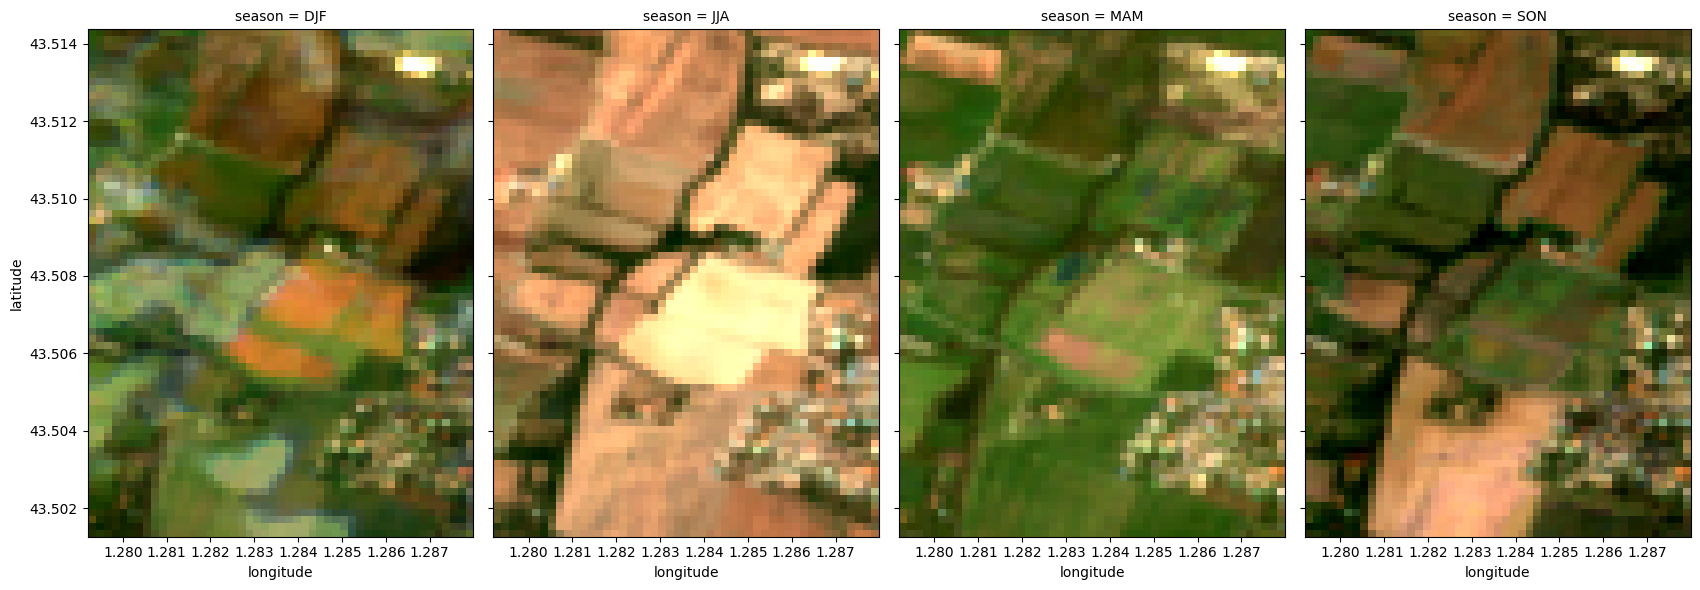

In [17]:
rgb(ds_groupby_season,col="season", bands=["B04", "B03", "B02"])